In [23]:
%reset -f

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
%matplotlib inline

In [25]:
from scipy.io.wavfile import read, write

In [26]:
pitch = 392.0
inp_name = 'organ.wav'
target = 'reed.wav'
savename = 'organtoreed2.wav'

In [27]:
def pitch_estimator(df,X,freq_res,amp_tol,fs):
    N = len(X)
    binw = int(np.ceil(N*0.1*freq_res/fs))
    
    k = int(np.ceil(N/binw))
    newlen = k*binw
    
    X_ = np.concatenate((np.abs(X),np.zeros(newlen-N)))
    
    del X, freq_res, newlen
    
    T = np.reshape(X_,(binw,k),order='F')
    del X_,k
    
    B = np.mean(T,axis=0)
    del T
    
    Amax = np.amax(B)
    
    Peakindex = find_peaks(B,height=amp_tol*Amax)[0]
    del B
    
    maxorder = len(Peakindex)
    n = np.arange(1,maxorder+1,1)
    
    z = np.polyfit(n,Peakindex,1)
    pitch = (binw*z[0]*fs)/(2*N)
    
    del z, binw, Peakindex, n, fs, N
    
    return pitch, maxorder

In [28]:
def pitchrefine(pitch):
    index = round(12*np.log2(pitch/440.0))
    refined = 440.0*2**(index/12)
    return refined

In [29]:
def pitch_extract(inp, ampmaxindex, fs, freq_res, amp_tol):
    window_size = np.ceil(fs/freq_res)
    p = int(np.ceil(np.log2(window_size)))
    window_size = 2**p
    
    x = (inp[ampmaxindex:ampmaxindex+window_size])*(np.hamming(window_size))
    del inp
    
    X = (1/window_size)*np.fft.fftshift(np.fft.fft(x))
    df = fs/window_size
    
    half_len = int(window_size/2)
    X_ = np.abs(X[half_len:-1])
        
    del x
    del p
    del window_size
    del X
    del half_len
    
    pitch_, maxorder = pitch_estimator(df,X_,freq_res,amp_tol,fs)
    pitch = pitchrefine(pitch_)
    
    return pitch, maxorder

In [30]:
def env(x,fs,freq_res,pitch,maxorder):
    L = len(x)
    
    t = np.arange(0,L/fs,1/fs)
    n = np.arange(0,maxorder+1,1)
    T, N = np.meshgrid(t,n)
    Mult = np.exp(-2*np.pi*1.j*T*N*(pitch))
    
    del n,T,N
    
    O = x*Mult
    del Mult, x
    
    window1 = int(np.ceil(10*fs/pitch))
    window2 = int(np.ceil(3*fs/pitch))
    
    Env_amp = np.zeros((maxorder+1,L-window1+1))
    Env_phi = np.zeros((maxorder+1,L-window1+1))
    
    M = L-window1+1
    
    mva1 = (1/window1)*np.ones(window1)
    mva2 = (1/window2)*np.ones(window2)
    
    t = t[0:L-window1+1]   
    
    for i in range(len(O)):
        temp = (np.convolve(mva1,O[i]))[window1-1:L]
        
        Env_amp[i] = np.abs(temp)
        Env_phi[i] = np.unwrap(np.angle(temp))
        
        Env_amp[i] = np.convolve(mva2,Env_amp[i])[window2-1:M+window2-1]
        Env_phi[i] = np.convolve(mva2,Env_phi[i])[window2-1:M+window2-1]
        plt.plot(t,Env_amp[i],label=str(i))
    plt.legend()
    plt.show()
    
    return Env_amp,Env_phi, t

493.8833012561241


C:\Users\Shilpa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


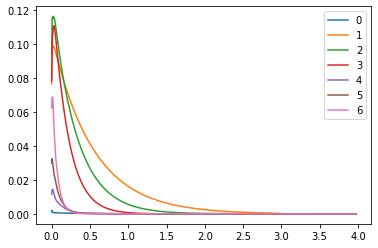

In [31]:
fs, x = read(inp_name)
max_ = np.max(np.abs(x))
x = (x/max_).astype(np.float32)

ampmax_index = np.argmax(x)
freq_res = 5.0
amp_tol = 0.1
    
pitch_t, maxorder = pitch_extract(x,ampmax_index,fs,freq_res,amp_tol)
print(pitch_t)
Env_amp,Env_phi, t = env(x,fs,freq_res,pitch,maxorder)

In [32]:
def time_sync(Env_amp,t,frac):
    
    sumsq_amp = np.sum(Env_amp[1:,:]**2,axis=0)
    max_amp_arg = np.argmax(sumsq_amp)
    ampmax = sumsq_amp[max_amp_arg]
    t_max = t[max_amp_arg]
    
    ii = np.where(np.abs(sumsq_amp-frac*ampmax)<.01*ampmax)
    temp_index = ii[0]
    temp_index = np.append(temp_index,max_amp_arg)
    temp_index = np.sort(temp_index)
    
    sync_params_index = [None,max_amp_arg,None]
    
    ii = np.where(temp_index==max_amp_arg)
    
    if sumsq_amp[0]>frac*ampmax:
        t_start=0.
        sync_params_index[0] = 0
    else:
        sync_params_index[0] = temp_index[ii[0][0]-1]
        t_start = t[temp_index[ii[0]-1]]
    
    if sumsq_amp[-1]>frac*ampmax:
        t_end = t[-1]
        sync_params_index[2] = len(t)-1
    else:
        sync_params_index[2] = temp_index[ii[0][0]+1]
        t_end = t[temp_index[ii[0]+1]]
    
    plt.plot(t,sumsq_amp)
    plt.axvline(x=t_start)
    plt.axvline(x=t_max)
    plt.axvline(x=t_end)
    plt.show()
    tsync_params = [t_start, t_max, t_end]
    
    return tsync_params,sync_params_index

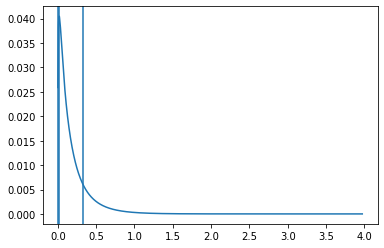

In [33]:
t_sync_params,sync_params_index = time_sync(Env_amp,t,0.37**2)

In [34]:
def refine_pitch(pitch,Env_amp,Env_phi,tsync_params,sync_params_index):
    
    ampmax_harm = np.max(Env_amp[1:,:],axis=1)
    deltaphi =  Env_phi[1:,sync_params_index[2]]-Env_phi[1:,sync_params_index[0]]
    
    temp = deltaphi/(2*np.pi*(tsync_params[2]-tsync_params[0]))
    deltaf = np.sum((ampmax_harm**2)*temp)
    
    pitch_refined = pitch+deltaf
    return pitch_refined

In [35]:
pitch_refined = refine_pitch(pitch,Env_amp,Env_phi,t_sync_params,sync_params_index)

391.67772768322124


C:\Users\Shilpa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


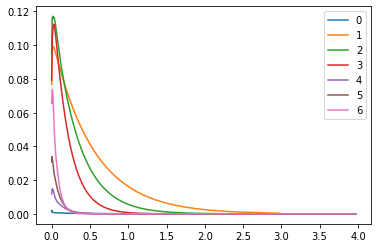

In [36]:
print(pitch_refined)
Env_amp,Env_phi, t = env(x,fs,freq_res,pitch_refined,maxorder)

In [37]:
u1,s1,vh1 = np.linalg.svd(Env_amp[1:,:].T,full_matrices=False)

In [38]:
del t, Env_amp, Env_phi

523.2511306011972


C:\Users\Shilpa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


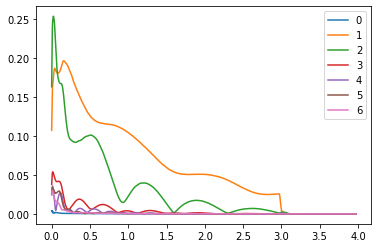

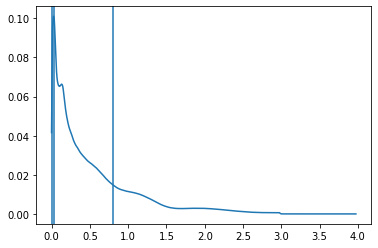

391.88471089078126


C:\Users\Shilpa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


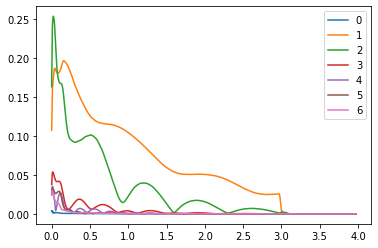

In [39]:
fs, x = read(target)
#x = x[:,0]
max_ = np.max(np.abs(x))
x = (x/max_).astype(np.float32)

ampmax_index = np.argmax(x)
freq_res = 5.0
amp_tol = 0.1
    
pitch_t, maxorder_ = pitch_extract(x,ampmax_index,fs,freq_res,amp_tol)
print(pitch_t)
Env_amp,Env_phi, t = env(x,fs,freq_res,pitch,maxorder)
t_sync_params,sync_params_index = time_sync(Env_amp,t,0.37*0.37)
pitch_refined = refine_pitch(pitch,Env_amp,Env_phi,t_sync_params,sync_params_index)
print(pitch_refined)
Env_amp,Env_phi, t = env(x,fs,freq_res,pitch_refined,maxorder)
u2,s2,vh2 = np.linalg.svd(Env_amp[1:,:].T,full_matrices=False)

In [40]:
len(u1)

63592

C:\Users\Shilpa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


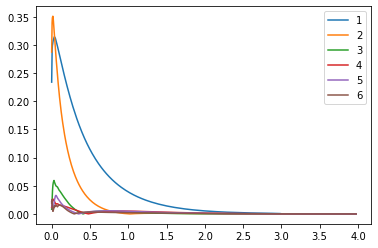

In [41]:
env_cast = u1@np.diag(s2)@vh2
#env_cast = env_cast+Env_mean2
t = np.arange(0,(1/fs)*len(env_cast[:,0]),1/fs)
for i in range(len(env_cast[0])):
    plt.plot(t,np.abs(env_cast[:,i]),label=str(i+1))
plt.legend()
plt.show()

In [42]:
desired_name = 'organtoreed2'
np.savez(desired_name+'.npz',env_cast)

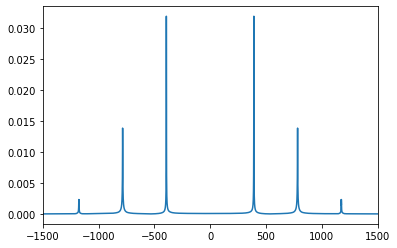

In [43]:
temp = env_cast.T
n = np.arange(1,len(env_cast[0])+1,1)

T, N = np.meshgrid(t,n)
Mult = np.sin(2*np.pi*N*pitch_refined*T)
del n,N,T
out = temp*Mult
del Mult
out = np.sum(out,axis=0)
m = np.max(np.abs(out))
sigf32 = (out/m).astype(np.float32)
write(savename,fs,sigf32)

f = np.linspace(-fs/2,fs/2,len(t)+1)[:-1]
S = (1/len(t))*np.fft.fftshift(np.fft.fft(sigf32))
plt.plot(f,np.abs(S))
plt.xlim([-1500,1500])
plt.show()

In [44]:
%reset -f